## Overview inspection of data and EDA

In [94]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
sns.set()

In [7]:
# ========================= Importing of data and addition of region information ============================
df = pd.read_csv('RentingOutofFlats2024CSV.csv') # No missing values found
df['rent_approval_date'] = pd.to_datetime(df['rent_approval_date'])
df['year'] = df['rent_approval_date'].dt.year
df['month'] = df['rent_approval_date'].dt.month
df = df.sort_values(by='rent_approval_date')

region_mapping = pd.read_excel('region_mapping.xlsx') # Data from https://en.wikipedia.org/wiki/Planning_Areas_of_Singapore,
region_mapping.rename(columns={'Name\xa0(English)':'town','Region':'region'},inplace=True)
region_mapping['town'] = region_mapping['town'].str.upper()
df = df.merge(region_mapping[['town','region']], on=['town'], how='left')
df['region'] = df['region'].fillna('Central') # KALLANG/WHAMPOA and CENTRAL is in central

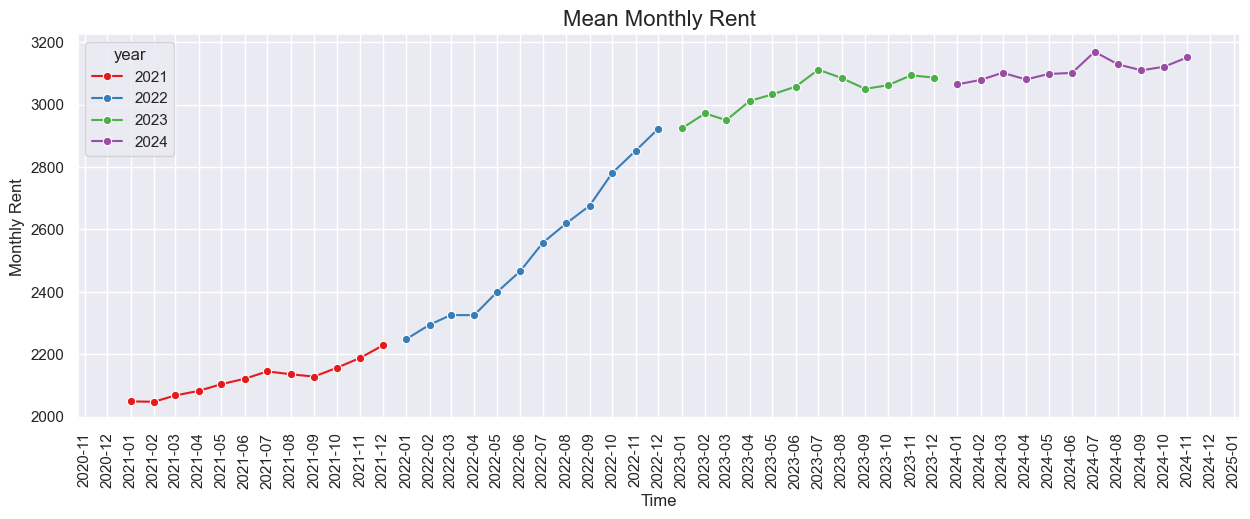

In [2]:
# ========================= Monthly Rent against time analysis ============================
plt.figure(figsize=(15, 5))
sns.lineplot(data=df, x='rent_approval_date', y='monthly_rent', ci=None, marker='o', hue='year', palette='Set1')
plt.title('Mean Monthly Rent', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Mean Monthly Rent', fontsize=12)
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m')) 
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.show()

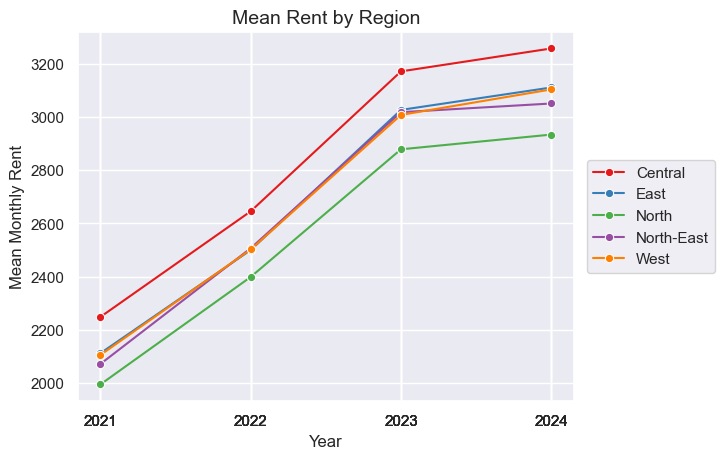

In [59]:
# ========================= Monthly Rent against region analysis ============================
rent_by_region_year_df = df.groupby(['region', 'year'])['monthly_rent'].mean().reset_index()
rent_by_region_year_df.rename(columns={'monthly_rent': 'mean_region_rent_by_year'},inplace = True)
sns.lineplot(data=rent_by_region_year_df, x='year', y='mean_region_rent_by_year', hue='region',ci=None, marker='o', palette='Set1')
plt.title('Mean Rent by Region', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mean Monthly Rent', fontsize=12)
plt.xticks(rent_by_region_year_df['year'])
plt.legend(loc='center right',bbox_to_anchor=(1.3,0.5))
plt.show()

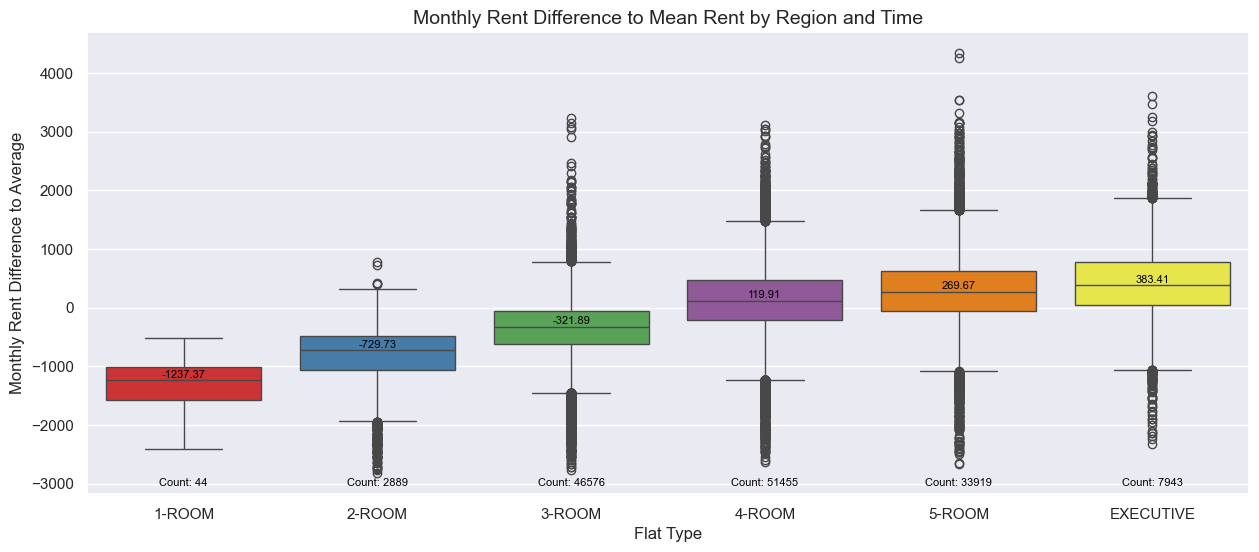

In [125]:
# ========================= Impact of flat type on monthly rent ============================
df['rent_by_month_year_region'] = df.groupby(['year','month','region'])['monthly_rent'].transform('mean')
df['rental_diff_to_time_region'] = df['monthly_rent'] - df['rent_by_month_year_region']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6), constrained_layout=False)
sns.boxplot(y='rental_diff_to_time_region',x='flat_type',data=df,ax=ax, palette='Set1', order=['1-ROOM','2-ROOM','3-ROOM','4-ROOM','5-ROOM','EXECUTIVE'])
plt.title('Monthly Rent Difference to Mean Rent by Region and Time', fontsize=14)
plt.xlabel('Flat Type', fontsize=12)
plt.ylabel('Monthly Rent Difference to Average', fontsize=12)

flat_type_counts = df['flat_type'].value_counts()
# Add the count as text above the boxplot
for i, flat_type in enumerate(['1-ROOM', '2-ROOM', '3-ROOM', '4-ROOM', '5-ROOM', 'EXECUTIVE']):
    count = flat_type_counts[flat_type]
    ax.text(i, -2900, f'Count: {count}', ha='center', va='top', fontsize=8, color='black')

means = df.groupby('flat_type')['rental_diff_to_time_region'].median()
# Overlay the median values as text inside the box
for i, flat_type in enumerate(['1-ROOM', '2-ROOM', '3-ROOM', '4-ROOM', '5-ROOM', 'EXECUTIVE']):
    mean_value = means[flat_type]
    ax.text(i, mean_value+100, f'{mean_value:.2f}', color='black', ha='center', va='center', fontsize=8)

plt.show()

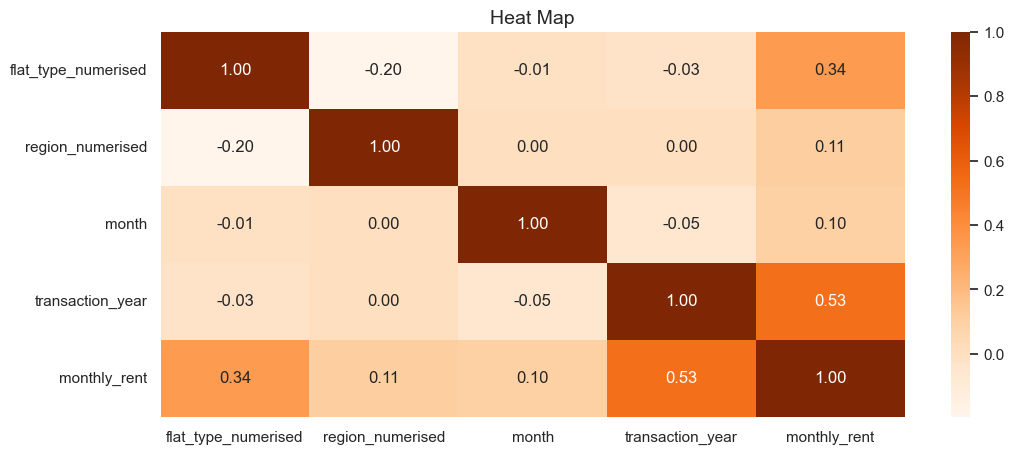

In [83]:
# ========================= Correlation plot of features ============================
flat_type_encoding = {'1-ROOM':1, '2-ROOM':2, '3-ROOM':3, '4-ROOM':4, '5-ROOM':5,'EXECUTIVE':6}
year_encoding = {2021:1, 2022:2, 2023:3, 2024:4}
region_encoding = {'North':1, 'North-East':2, 'West':3, 'East':4, 'Central':5}

df['flat_type_numerised'] = df['flat_type'].replace(flat_type_encoding)
df['transaction_year'] = df['year'].replace(year_encoding)
df['region_numerised'] = df['region'].replace(region_encoding)
matrix_corr = df[['flat_type_numerised', 'region_numerised', 'month', 'transaction_year', 'monthly_rent']].corr()

plt.figure(figsize=(12, 5))
sns.heatmap(matrix_corr, annot=True, fmt=".2f", cmap='Oranges')
plt.title('Heat Map', fontsize=14)
plt.show()

## Machine learning model for feature importance

In [92]:
def data_processing(df):
    
    features_to_use = ['region', 'flat_type_numerised', 'year', 'month']
    y_train = df[['monthly_rent']].copy()
    X_train = df[features_to_use].copy()
    num_attribs=X_train.select_dtypes([np.number]).columns.tolist()
    cat_attribs=X_train.select_dtypes(exclude=[np.number]).columns.tolist()
    df_num=X_train[num_attribs]
    df_cat=pd.get_dummies(X_train[cat_attribs])
    df_cat.reset_index(inplace=True, drop=True)
    X_train=pd.concat([df_num,df_cat], axis=1)
    y_train=y_train.values.ravel()

    return X_train, y_train

def permutate_impt(X, y):

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)
    my_model = RandomForestRegressor(random_state=1,n_jobs=-1).fit(X_train, y_train)
    importances=pd.Series(my_model.feature_importances_, index=X_test.columns).sort_values(ascending=False)
    importances = importances.reset_index().rename(columns = {'index':'Feature',0:'Random Forest Importance Value'}) 
    return importances

def make_mi_scores(X, y):

    X = X.copy()
    mi_scores = mutual_info_regression(X, y, discrete_features=True, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    print('Most important feature:')

    return mi_scores

In [93]:
X_train, y_train = data_processing(df)
importances = permutate_impt(X_train,y_train)
print(importances)

,Feature,Random Forest Importance Value
0,year,0.562186
1,flat_type_numerised,0.289143
2,region_Central,0.075501
3,month,0.058300
4,region_North,0.008655
5,region_North-East,0.002249
6,region_East,0.002217
7,region_West,0.001749
